Follow the steps to test the performance of different models.

The linear regression model is based on polynomial distributions where the input is the pythagorean expectation and the output is the likelihood of a particular outcome (home win, away win, draw). A graph of the regression for all 3 outcomes will display after running the cell for step 2.

The second model relies on constructing a gamma pdf for the distribution of each teams xG, and then integrating over the resulting curve to calculate the probability of individual match outcomes. The draw parameters are: xG difference less than .325 coupled with randomly selecting an additional 2.5% of results and labeling them as draws, to smooth out the resulting distribution of potential outcomes. The random sample was derived from recognizing that, relative to home and away win probability, the likelihood of a draw is much flatter. 

Running the optional cell after the second model will display the gamma PDF curves for both the home team and away team from the last game in the dataset.

Additional areas of research: implementing deep learning techniques to model the given data, game state research, and getting/using player level data.

In [ ]:
#@title Step 1: Data Loader { run: "auto", display-mode: "form" }

import ipywidgets as widgets
from IPython.display import display
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from scipy.stats import gamma
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
from datetime import datetime

global game_data, spi_matches_league
spi_matches = pd.read_csv('/content/drive/My Drive/Sports Data Analysis/Soccer Data/538 SPI Data/spi_matches.csv')
leagues = ["LaLiga", "Bundesliga", "EPL", "Eredivisie"]

def LaLiga():
  global game_data, spi_matches_league
  now = datetime.now()
  print('Start running La Liga at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/La Liga.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_La_Liga.csv')
  now = datetime.now()
  print("La Liga processed at: ", now)

def Bundesliga():
  global game_data, spi_matches_league
  now = datetime.now()
  print('Start running Bundesliga at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/Bundesliga.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_Bundesliga.csv')
  now = datetime.now()
  print("Bundesliga processed at: ", now)

def EPL():
  global game_data, spi_matches_league
  now = datetime.now()
  print('Start running EPL at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/EPL.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_EPL.csv')
  now = datetime.now()
  print("EPL processed at: ", now)

def Eredivisie():
  global game_data, spi_matches_league
  now = datetime.now()
  print('Start running Eredivisie at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/Eredivisie.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_Eredivisie.csv')
  now = datetime.now()
  print("Eredivisie processed at: ", now)

def AllLeagues():
  global game_data, spi_matches_league
  now = datetime.now()
  print('Start running all leagues at: ', now)
  game_data = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/La Liga.csv')
  spi_matches_league = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_La_Liga.csv')
  temp_gd = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/EPL.csv')
  temp_spi = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_EPL.csv')
  game_data = game_data.append(temp_gd).reset_index(drop=True)
  spi_matches_league = spi_matches_league.append(temp_spi).reset_index(drop=True)
  temp_gd = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/Bundesliga.csv')
  temp_spi = pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_Bundesliga.csv')
  game_data = game_data.append(temp_gd).reset_index(drop=True)
  spi_matches_league = spi_matches_league.append(temp_spi).reset_index(drop=True)

  # TODO
  # I think it'll time out if I try all 4 leagues
  # This is something worth investigating
  
  #game_data.append(pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/Eredivisie.csv'))
  #spi_matches_league.append(pd.read_csv('/content/drive/MyDrive/Sports Data Analysis/Soccer Data/Processed Data/spi_matches_Eredivisie.csv'))

  now = datetime.now()
  print('All Leagues processed at: ', now)
  
league_dropdown = Bundesliga #@param ["LaLiga", "Bundesliga", "EPL", "Eredivisie", "AllLeagues"]{type:"raw"}
league_dropdown()

Start running Bundesliga at:  2022-09-02 01:54:25.354284
Bundesliga processed at:  2022-09-02 01:54:25.448111


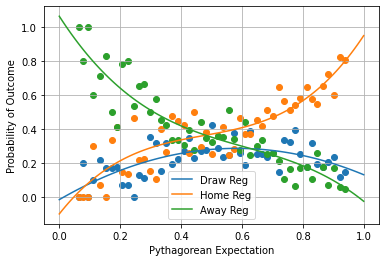

In [ ]:
#@title Step 2: Project xG with Gamma Regression { display-mode: "form" }

# This cell creates initial xG projections
from sklearn.metrics import r2_score

mode = "Test Mode" #@param ["Test Mode", "Production Mode"]{type:"string"}
show_results = False #@param {type: "boolean"}

if mode == "Test Mode":
  sample_data = game_data[game_data['Season'] < 2021].reset_index(drop=True)
  test_data = game_data[game_data['Season'] >= 2021].reset_index(drop=True)
else:
  sample_data = game_data[game_data['Season'] < 2021].reset_index(drop=True)
  test_data = game_data[game_data['Season'] >= 2021].reset_index(drop=True)


sample_home = [[sample_data['Home Atk'][x], sample_data['Away Def'][x]] for x in range(len(sample_data))]
sample_away = [[sample_data['Away Atk'][x], sample_data['Home Def'][x]] for x in range(len(sample_data))]

gld_home = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_away = linear_model.TweedieRegressor(power=2, alpha=0.0, link='log', warm_start=False)
gld_home.fit(sample_home, np.array(sample_data['Home Goals']))
gld_away.fit(sample_away, np.array(sample_data['Away Goals']))

pred_home = [[test_data['Home Atk'][x], test_data['Away Def'][x]] for x in range(len(test_data))]
pred_away = [[test_data['Away Atk'][x], test_data['Home Def'][x]] for x in range(len(test_data))]
model_xg_home = gld_home.predict(pred_home)
model_xg_away = gld_away.predict(pred_away)
             
test_data['Gamma Pred Home'] = np.array(model_xg_home)
test_data['Gamma Pred Away'] = np.array(model_xg_away)
test_data['Gamma Pred Pythag'] = np.divide(np.multiply(model_xg_home, model_xg_home), np.add(np.multiply(model_xg_home, model_xg_home), np.multiply(model_xg_away, model_xg_away)))

poly_data = spi_matches_league[spi_matches_league['season'] < 2021]
poly_data = poly_data[poly_data['score1'].notna()]
poly_data = poly_data[poly_data['proj_score1'].notna()]
poly_data['result'] = np.array(poly_data['score1']) - np.array(poly_data['score2'])
proj_score1 = np.array(poly_data['proj_score1'])
proj_score2 = np.array(poly_data['proj_score2'])
proj_pythag = np.divide(np.multiply(proj_score1, proj_score1), np.add(np.multiply(proj_score1, proj_score1), np.multiply(proj_score2, proj_score2)))
poly_data['pythag'] = proj_pythag
poly_data = poly_data.sort_values(['pythag']).reset_index(drop=True)
if (len(poly_data['league'].unique()) > 1):
  bin_size = np.linspace(0.05, .95, 100)
else:
  bin_size = np.linspace(0.05, .95, 50)
bin_indices = [len(poly_data[poly_data['pythag'] < x]) for x in bin_size]
bins = [poly_data.iloc[bin_indices[x]:bin_indices[x+1]] for x in range(len(bin_indices) - 1)]
avg_pythag = [bin['pythag'].mean() for bin in bins]
draw_percent = [len(bin[bin['result'] == 0]) / len(bin) for bin in bins]
home_percent = [len(bin[bin['result'] > 0]) / len(bin) for bin in bins]
away_percent = [len(bin[bin['result'] < 0]) / len(bin) for bin in bins]

draw_reg = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(avg_pythag, draw_percent, 2).convert().coef)
proj_draws = [draw_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]
test_data['Draw Prob'] = np.array(proj_draws)
pred_draws = [draw_reg(a) for a in avg_pythag]

home_reg = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(avg_pythag, home_percent, 3).convert().coef)
proj_home = [home_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]
test_data['Home Prob'] = np.array(proj_home)
pred_home = [home_reg(a) for a in avg_pythag]

away_reg = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(avg_pythag, away_percent, 3).convert().coef)
proj_away = [away_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]
test_data['Away Prob'] = np.array(proj_away)
pred_away = [away_reg(a) for a in avg_pythag]

# TODO
# revisit different potential calculations for theory_home and theory_away
# ex: theory_home = 'Gamma Pred Pythag' / 'Gamma Pred Pythag'.mean() * sample_data['Home Goals'].mean()
theory_home = np.array(test_data['Gamma Pred Pythag']) - test_data['Gamma Pred Pythag'].mean()
theory_home = (1.0 + theory_home) * (sample_data['Home Goals'].mean())
theory_away = test_data['Gamma Pred Pythag'].mean() - np.array(test_data['Gamma Pred Pythag'])
theory_away = (1.0 + theory_away) * (sample_data['Away Goals'].mean())
test_data['Theory_home'] = np.array(theory_home)
test_data['Theory_away'] = np.array(theory_away)

if show_results:
  print("\nGamma distribution correlation")
  print(test_data['Gamma Pred Home'].corr(test_data['Home Goals']))
  print(test_data['Gamma Pred Away'].corr(test_data['Away Goals']))

  print("\nSPI correlation")
  print(spi_matches_league['proj_score1'].corr(spi_matches_league['xg1']))
  print(spi_matches_league['proj_score2'].corr(spi_matches_league['xg2']))

  print("\nLeague Average Goals Scored")
  print(spi_matches_league['xg1'].mean())
  print(spi_matches_league['xg2'].mean())

  print("\nGamma pythagorean correlation")
  print(test_data['Gamma Pred Pythag'].corr(test_data['Pythag']))
  print('Draw stats')
  print(len(test_data[test_data['Draw Prob'] < .2]))
  print(len(test_data[test_data['Draw Odds'] < .2]))
  print(test_data['Draw Prob'].mean())
  print('r^2: ', r2_score(draw_percent, pred_draws))
  print('corr: ', test_data['Draw Prob'].corr(test_data['Draw Odds']))
  print('Home stats')
  print(len(test_data[test_data['Home Prob'] < .2]))
  print(len(test_data[test_data['Home Odds'] < .2]))
  print(test_data['Home Prob'].mean())
  print('r^2: ', r2_score(home_percent, pred_home))
  print('corr: ', test_data['Home Prob'].corr(test_data['Home Odds']))
  print('Away stats')
  print(len(test_data[test_data['Away Prob'] < .2]))
  print(len(test_data[test_data['Away Odds'] < .2]))
  print(test_data['Away Prob'].mean())
  print('r^2: ', r2_score(away_percent, pred_away))
  print('corr: ', test_data['Away Prob'].corr(test_data['Away Odds']))

  print('\nLeague Average Goals Predicted - Gamma')
  print(test_data['Gamma Pred Home'].mean())
  print(test_data['Home Goals'].mean())
  print(test_data['Gamma Pred Away'].mean())
  print(test_data['Away Goals'].mean())

  print('\nTheory home and away goals, with correlation to xG')
  print(test_data['Home Goals'].corr(pd.Series(theory_home)))
  print(theory_home.mean())
  print(test_data['Away Goals'].corr(pd.Series(theory_away)))
  print(theory_away.mean())

  print('\nGamma Pythag vs Sample Pythag')
  print(test_data['Gamma Pred Pythag'].mean())
  print(test_data['Pythag'].mean())

myspace = np.linspace(0, 1, 100)
plt.plot(myspace, draw_reg(myspace), label='Draw Reg')
plt.plot(myspace, home_reg(myspace), label='Home Reg')
plt.plot(myspace, away_reg(myspace), label='Away Reg')
plt.scatter(avg_pythag, draw_percent)
plt.scatter(avg_pythag, home_percent)
plt.scatter(avg_pythag, away_percent)
plt.grid(visible=True)
plt.xlabel('Pythagorean Expectation')
plt.ylabel('Probability of Outcome')
plt.legend()
plt.show()

Step 3: Run one of the available models listed below. If you run multiple models, the last one executed is the one that will be used.

In [ ]:
#@title Model 1: Polynomial Regression { display-mode: "form" }

draw_pred = [draw_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]
home_pred = [home_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]
away_pred = [away_reg(test_data['Gamma Pred Pythag'].iloc[x]) for x in range(len(test_data))]

# This block will normalize the ratio of predicted home wins, away wins, and draws
# Given the model underestimates home wins relative to the other possible outcomes
# home wins are set, and the adjustment comes from the other outcomes
#total_percent = np.add(draw_pred, away_pred)
#home_pred = np.array(home_pred)
#draw_pred = np.multiply(np.divide(draw_pred, total_percent), (1 - home_pred))
#away_pred = np.multiply(np.divide(away_pred, total_percent), (1 - home_pred))

test_data['Home Prob'] = home_pred
test_data['Away Prob'] = away_pred
test_data['Draw Prob'] = draw_pred

In [ ]:
#@title Model 2: Integrate Over Gamma PDF { display-mode: "form" }
#@markdown This takes ~23 minutes per league

# TODO:
# alter kNN to use home atk/def and away atk/def ratings instead of SPI
# I want to shift away from a reliance on SPI, and build sustainably
# which requires every be based on xG, which can be found/calculated from a wide range of sources

import scipy.integrate as integrate
import random as rand

def CalcIntegral(a, b, constraints_home, constraints_away):
  mean = (a + b) / 2
  result_home = integrate.quad(lambda x: gamma.pdf(x, constraints_home[0], loc=constraints_home[1], scale=constraints_home[2]), a, b)
  result_away = integrate.quad(lambda x: gamma.pdf(x, constraints_away[0], loc=constraints_away[1], scale=constraints_away[2]), a, b)
  return [mean, result_home[0], result_away[0]]

n = 75
neigh_home = NearestNeighbors(n_neighbors=n)
neigh_away = NearestNeighbors(n_neighbors=n)
sample_data = spi_matches_league[spi_matches_league['season'] < 2021]
sample_data = sample_data.dropna()
sample_data = sample_data.reset_index(drop=True).replace(to_replace=0, value=0.01)

knn_sample_home = [[sample_data['proj_score1'].iloc[x]] for x in range(len(sample_data))]
knn_sample_away = [[sample_data['proj_score2'].iloc[x]] for x in range(len(sample_data))]
neigh_home.fit(knn_sample_home)
neigh_away.fit(knn_sample_away)

knn_result_home = [neigh_home.kneighbors([[test_data['Theory_home'][x]]]) for x in range(len(test_data))]
knn_result_away = [neigh_away.kneighbors([[test_data['Theory_away'][x]]]) for x in range(len(test_data))]

# A note about the the format of the returned data from kNN.kneighbors
# it is returned as a 4 dimensional array
# the first dimension is index of the element from test_data
# the second is 0 for an array containing the distances of the test data to sample neighbors
# or 1 for an array of indices of neighbors in the sample data
# the third is empty and therefore always 0; this results from the nested structure of the input data
# the fourth is an individual distance or index of a neighbor of the sample data

indices_home = [knn_result_home[x][1][0] for x in range(len(knn_result_home))]
indices_away = [knn_result_away[x][1][0] for x in range(len(knn_result_away))]

integral_values = np.empty([len(test_data), 499, 3])

a = np.linspace(0, 8, 500)
r1 = range(len(indices_home))
r2 = range(len(a) - 1)
for x in r1:
  gamma_sample_home = [sample_data['xg1'].iloc[indices_home[x][z]] for z in range(n)]
  gamma_sample_away = [sample_data['xg2'].iloc[indices_away[x][z]] for z in range(n)]
  
  # constraints are the [0] shape parameter, [1] loc parameter, [2] scale parameter
  constraints_home = gamma.fit(gamma_sample_home)
  constraints_away = gamma.fit(gamma_sample_away)
  for i in r2:
    integral_values[x][i] = CalcIntegral(a[i], a[i+1], constraints_home, constraints_away)

# Integral Values are stored in a 3 dimensional array
# the first dimension corresponds to the index of the match in test_data
# the second 
r1 = range(len(test_data))
r2 = range(len(a) - 1)
odds = np.empty([len(test_data), 3])
for i in r1:
  home_odds = 0
  away_odds = 0
  draw_odds = 0
  for j in r2:
    for k in r2:
      if (abs(integral_values[i][j][0] - integral_values[i][k][0]) < .325):
        draw_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif rand.random() < .025:
        draw_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif (integral_values[i][j][0] > integral_values[i][k][0]):
        home_odds += (integral_values[i][j][1] * integral_values[i][k][2])
      elif (integral_values[i][k][0] > integral_values[i][j][0]):
        away_odds += (integral_values[i][j][1] * integral_values[i][k][2])
  odds[i] = [home_odds, away_odds, draw_odds]

test_data['Home Prob'] = [odds[x][0] for x in range(len(odds))]
test_data['Away Prob'] = [odds[x][1] for x in range(len(odds))]
test_data['Draw Prob'] = [odds[x][2] for x in range(len(odds))]

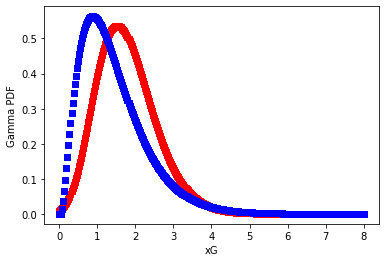

Season                 2021
Date             2022-03-05
Home Team         Wolfsburg
Away Team      Union Berlin
Home Goals             0.52
Away Goals              1.7
Home Atk            1.66675
Home Def              1.445
Away Atk            1.38725
Away Def            1.47875
Theory_home        1.589226
Theory_away        1.408389
Name: 301, dtype: object


In [ ]:
#@title Optional: Visualize Single Game PDF { display-mode: "form" }
#@markdown If you run the integration model, you can display the PDF's of the last game in the dataset by running this cell

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma

y = x
buckets = np.linspace(0, 8, num=300)
pdf_buckets_home = [gamma.pdf(buckets[x], constraints_home[0], constraints_home[1], constraints_home[2]) for x in range(len(buckets))]
pdf_buckets_away = [gamma.pdf(buckets[x], constraints_away[0], constraints_away[1], constraints_away[2]) for x in range(len(buckets))]
plt.scatter(buckets, pdf_buckets_home, c='red', marker='s')
plt.scatter(buckets, pdf_buckets_away, c='blue', marker='s')
plt.xlabel('xG')
plt.ylabel('Gamma PDF')
plt.show()
disp_cols = ['Season', 'Date', 'Home Team', 'Away Team', 'Home Goals', 'Away Goals', 'Home Atk', 'Home Def', 'Away Atk', 'Away Def', 'Theory_home', 'Theory_away']
print(test_data[disp_cols].iloc[y])

In [ ]:
#@title Step 4: Calculate Profit from Test Data { display-mode: "form" }

def CalcBet(df, x):
    threshold = .15
    if df['Draw Edge'].iloc[x] > (threshold):
        return 'D'
    max_edge = max(df['Home Edge'].iloc[x], df['Away Edge'].iloc[x])
    if max_edge < threshold:
        return 'No Bet'
    elif max_edge == df['Home Edge'].iloc[x]:
        return 'H'
    else:
        return 'A'
    
def CalcProfit(df, x):
    if df['Model Bet'].iloc[x] == 'No Bet':
        return 0
    elif df['Model Bet'].iloc[x] == df['Result'].iloc[x]:
        if df['Model Bet'].iloc[x] == 'H':
            return (1/df['Home Odds'].iloc[x] - 1)
        elif df['Model Bet'].iloc[x] == 'A':
            return (1/df['Away Odds'].iloc[x] - 1)
        else:
            return (1/df['Draw Odds'].iloc[x] - 1)
    else:
        return -1

test_data['Home Edge'] = [test_data['Home Prob'][x] - test_data['Home Odds'][x] for x in range(len(test_data))]
test_data['Away Edge'] = [test_data['Away Prob'][x] - test_data['Away Odds'][x] for x in range(len(test_data))]
test_data['Draw Edge'] = [test_data['Draw Prob'][x] - test_data['Draw Odds'][x] for x in range(len(test_data))]
test_data['Model Bet'] = [CalcBet(test_data, x) for x in range(len(test_data))]
test_data['Profit'] = [CalcProfit(test_data, x) for x in range(len(test_data))]

print('Total Profit: ', test_data['Profit'].sum(), ' on ', len(test_data[test_data['Model Bet'] != 'No Bet']), ' total bets')
print(test_data.loc[test_data['Model Bet'] == 'H', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'H']), ' H bets')
print(test_data.loc[test_data['Model Bet'] == 'A', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'A']), ' A bets')
print(test_data.loc[test_data['Model Bet'] == 'D', ['Profit']].sum(), ' on ', len(test_data[test_data['Model Bet'] == 'D']), ' D bets')

print('\nTotal games in the dataset: ', len(test_data))
print('Total games in the sample: ', len(sample_data))
print('\nAverage draw probability: ', test_data['Draw Prob'].mean())
print('Percentage of games drawn: ', len(test_data[test_data['Result'] == 'D']) / len(test_data))
print('Average implied probability of a draw: ', test_data['Draw Odds'].mean())

print('\nAverage home win probability: ', test_data['Home Prob'].mean())
print('Percentage of games won by home team: ', len(test_data[test_data['Result'] == 'H']) / len(test_data))
print('Average implied probability: ', test_data['Home Odds'].mean())

print('\nAverage away win probability: ', test_data['Away Prob'].mean())
print('Percentage of games won by away team: ', len(test_data[test_data['Result'] == 'A']) / len(test_data))
print('Average implied probability: ', test_data['Away Odds'].mean())

print('\nTotal Hold: ', (test_data['Draw Odds'].mean() + test_data['Home Odds'].mean() + test_data['Away Odds'].mean()))
print('Total projected probability: ', (test_data['Draw Prob'].mean() + test_data['Home Prob'].mean() + test_data['Away Prob'].mean()))

print('\nCorrelation between projected outcome probability and odds')
print('Home win: ', test_data['Home Prob'].corr(test_data['Home Odds']))
print('Away win: ', test_data['Away Prob'].corr(test_data['Away Odds']))
print('Draw: ', test_data['Draw Prob'].corr(test_data['Draw Odds']))


Total Profit:  16.750000000000007  on  26  total bets
Profit    7.25
dtype: float64  on  11  H bets
Profit    10.5
dtype: float64  on  14  A bets
Profit   -1.0
dtype: float64  on  1  D bets

Total games in the dataset:  1059
Total games in the sample:  4211

Average draw probability:  0.269114666457859
Percentage of games drawn:  0.254957507082153
Average implied probability of a draw:  0.2604668969501283

Average home win probability:  0.3964493522245774
Percentage of games won by home team:  0.4409820585457979
Average implied probability:  0.4622527707197884

Average away win probability:  0.3328068299552305
Percentage of games won by away team:  0.3040604343720491
Average implied probability:  0.3313294177181664

Total Hold:  1.054049085388083
Total projected probability:  0.9983708486376668

Correlation between projected outcome probability and odds
Home win:  0.895043351241845
Away win:  0.9042410614574685
Draw:  0.6813754138353804


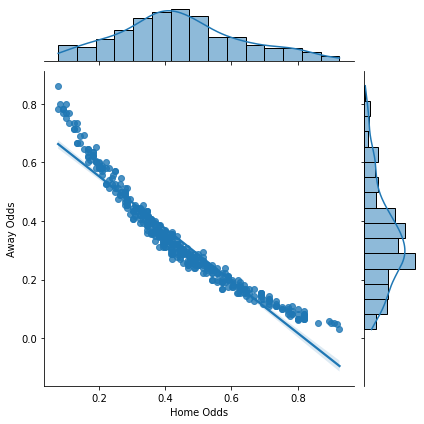

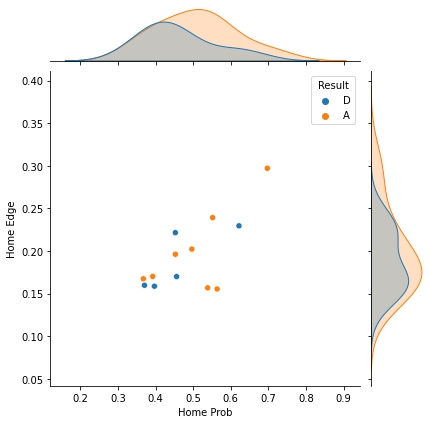

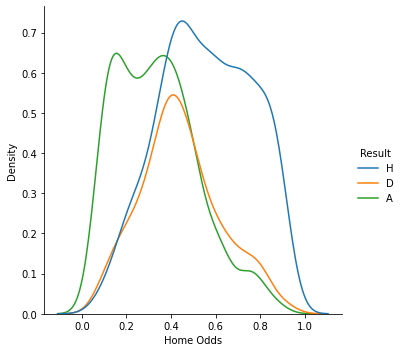

In [ ]:
import seaborn as sns

sns.jointplot(data=game_data.loc[game_data['Result'] == 'D'], x='Home Odds', y='Away Odds', kind='reg')

sns.jointplot(data=test_data[test_data['Model Bet'] == 'H'], x='Home Prob', y='Home Edge', hue='Result')
#sns.jointplot(data=test_data[test_data['Result'] == 'A'], x='Away Prob', y='Away Odds', hue='Model Bet')
#sns.jointplot(data=test_data[test_data['Result'] == 'D'], x='Draw Prob', y='Draw Odds', hue='Model Bet')

# These display the distribution of projected draws from me and SPI as a check; they should have similar shape
sns.displot(game_data, x='Home Odds', hue='Result', kind='kde')
#sns.displot(test_data['Draw Odds'])
#sns.displot(spi_matches_league['probtie'])

In [ ]:
#@title Calculate linear regression models for draws for all leagues in SPI database

# score1 and score2 represent the actual score of the game
from sklearn.metrics import r2_score
spi_matches = spi_matches[spi_matches['score1'].notna()]
spi_matches = spi_matches[spi_matches['proj_score1'].notna()]
spi_matches['result'] = np.array(spi_matches['score1']) - np.array(spi_matches['score2'])
spi_matches = spi_matches.sort_values(['prob1']).reset_index(drop=True)
proj_score1 = np.array(spi_matches['proj_score1'])
proj_score2 = np.array(spi_matches['proj_score2'])
proj_pythag = np.divide(np.multiply(proj_score1, proj_score1), np.add(np.multiply(proj_score1, proj_score1), np.multiply(proj_score2, proj_score2)))
spi_matches['pythag'] = proj_pythag
spi_matches = spi_matches.sort_values(['pythag']).reset_index(drop=True)

bin_size = np.linspace(0, 1, 50)
bin_indices = [len(spi_matches[spi_matches['pythag'] < x]) for x in bin_size]
bins = [spi_matches.iloc[bin_indices[x]:bin_indices[x+1]] for x in range(len(bin_indices) - 1)]
avg_pythag = [bin['pythag'].mean() for bin in bins]
draw_percent = [len(bin[bin['result'] > 0]) / len(bin) for bin in bins]
myline = np.polynomial.Polynomial(np.polynomial.Polynomial.fit(avg_pythag, draw_percent, 2).convert().coef)
myspace = np.linspace(0, 1, 200)
plt.plot(myspace, myline(myspace))
#plt.scatter(x, y)
plt.xlabel('Pythagorean Expectation')
plt.ylabel('Percentage of Games Drawn')
plt.ylim(0, .5)
plt.xlim(0, 1)

leagues = spi_matches['league'].unique()

for league in leagues:
  league_data = spi_matches[spi_matches['league'] == league].sort_values(['pythag']).reset_index(drop=True)
  bin_size = np.linspace(0, 1, 10)
  bin_indices = [len(league_data[league_data['pythag'] < x]) for x in bin_size]
  bins = [league_data.iloc[bin_indices[x]:bin_indices[x+1]] for x in range(len(bin_indices) - 1)]
  avg_pythag = [bin['pythag'].mean() for bin in bins]
  if np.nan in avg_pythag:
    continue
  draw_percent = [len(bin[bin['result'] > 0]) / len(bin) for bin in bins]

  plt.scatter(avg_pythag, draw_percent)
  pred = [myline(a) for a in avg_pythag]
  print(league, ' regression: ', myline)
  print(league, ' r^2: ', r2_score(draw_percent, pred))
  print('Sample size: ', len(league_data))
  print('Average goals scored per game: ', (league_data['score1'].mean() + league_data['score2'].mean()))
  print(' ')

plt.show()
